In [ ]:
# Google Colab Setup
try:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    import sys

    # Path to the project root in Google Drive
    project_root = '/content/drive/MyDrive/ComputerVisionTest'

    if os.path.exists(project_root):
        # Change to project root to install requirements
        os.chdir(project_root)
        print("Installing requirements...")
        !pip install -q -r requirements.txt

        # Add project root to sys.path
        if project_root not in sys.path:
            sys.path.append(project_root)
            print(f"Added {project_root} to sys.path")

        # Change directory to 'notebooks' so relative paths work
        notebooks_dir = os.path.join(project_root, 'notebooks')
        if os.path.exists(notebooks_dir):
            os.chdir(notebooks_dir)
            print(f"Changed directory to {notebooks_dir}")
    else:
        print(f"Warning: Project root {project_root} not found. Please check your Drive path.")

except ImportError:
    # Local Machine Setup
    import os
    import sys

    # Get the path to the project root (assuming running from notebooks/)
    current_dir = os.getcwd()
    if current_dir.endswith('notebooks'):
        project_root = os.path.abspath('..')
    else:
        project_root = os.path.abspath('.')

    if os.path.exists(os.path.join(project_root, 'src')):
         if project_root not in sys.path:
            sys.path.append(project_root)
            print(f"Added project root to sys.path: {project_root}")


# Part 4: Fine-Tuning (Unfreezing Backbone)

In this notebook, we will load the previously trained model (`best_model.pt`), unfreeze the backbone (ResNet50), and fine-tune it with a lower learning rate. This usually improves performance on granular tasks like flower classification.

In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Add src to path
sys.path.append(os.path.abspath('../'))

from src.data.loader import create_dataloaders
from src.models.base_model import get_model
from src.training.trainer import fit
from src.training.callbacks import EarlyStopping
from src.utils.seeds import set_seeds

# Set seeds for reproducibility
set_seeds(42)

Global seed set to 42


## 1. Setup Environment

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8 # Reduced batch size for 640x640 resolution to avoid OOM
NUM_EPOCHS = 15
LEARNING_RATE = 1e-5 # Lower learning rate for fine-tuning

print(f"Using device: {DEVICE}")

Using device: cpu


## 2. Load Data

In [3]:
train_loader, val_loader, test_loader = create_dataloaders(data_dir='../src/data', batch_size=BATCH_SIZE)

## 3. Load Model and Unfreeze

In [4]:
model = get_model(num_classes=102, fine_tune=False)
model_path = 'best_model.pt'

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    print("Loaded weights from best_model.pt")
else:
    print("Warning: best_model.pt not found. Starting fine-tuning from ImageNet weights (NOT RECOMMENDED without Stage 1).")

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

model = model.to(DEVICE)
print("Model backbone unfrozen.")

Loaded weights from best_model.pt
Model backbone unfrozen.


## 4. Setup Training Components
We use a much smaller learning rate to avoid destroying the pre-trained features.

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
early_stopping = EarlyStopping(patience=5, verbose=True, path='best_model_finetuned.pt')

## 5. Execute Fine-Tuning

In [6]:
model, history = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    NUM_EPOCHS,
    DEVICE,
    early_stopping
)

Training on cpu
Epoch 1/15 - Time: 177s
  Train Loss: 0.5666 Acc: 0.8882
  Val Loss: 0.4716 Acc: 0.8922 LR: 0.000010
Validation loss decreased (inf --> 0.471571).  Saving model ...
Epoch 2/15 - Time: 181s
  Train Loss: 0.4423 Acc: 0.9157
  Val Loss: 0.4173 Acc: 0.9049 LR: 0.000010
Validation loss decreased (0.471571 --> 0.417321).  Saving model ...
Epoch 3/15 - Time: 188s
  Train Loss: 0.3876 Acc: 0.9284
  Val Loss: 0.3924 Acc: 0.9078 LR: 0.000010
Validation loss decreased (0.417321 --> 0.392405).  Saving model ...
Epoch 4/15 - Time: 186s
  Train Loss: 0.3594 Acc: 0.9412
  Val Loss: 0.3758 Acc: 0.9098 LR: 0.000010
Validation loss decreased (0.392405 --> 0.375811).  Saving model ...
Epoch 5/15 - Time: 181s
  Train Loss: 0.3207 Acc: 0.9402
  Val Loss: 0.3604 Acc: 0.9186 LR: 0.000010
Validation loss decreased (0.375811 --> 0.360376).  Saving model ...
Epoch 6/15 - Time: 184s
  Train Loss: 0.3016 Acc: 0.9461
  Val Loss: 0.3670 Acc: 0.9127 LR: 0.000010
EarlyStopping counter: 1 out of 5
Epoc

## 6. History Plot

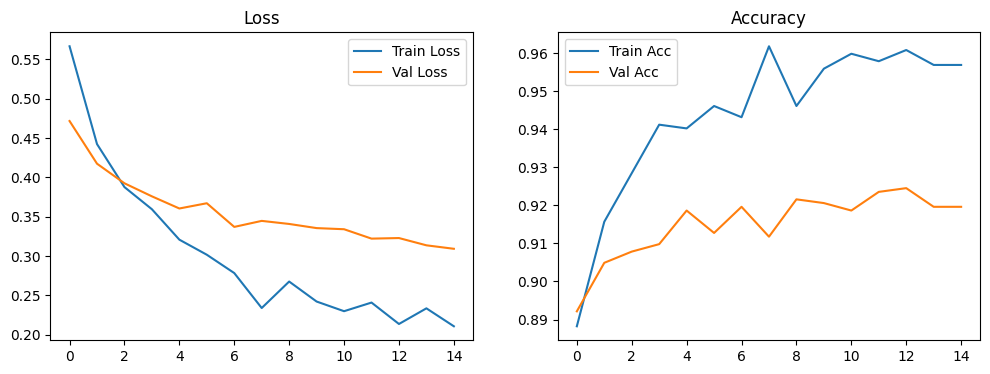

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.show()